# <center> TP n°4 - Canal radio mobile, préfixe cyclique et égalisation</center>

<!-- Image dans le même répertoire ![emetteur N mod complexe](images/image_notebook.png) -->

![image notebook](images/image_notebook.png)

<br>

<font size="5">Objectifs du TP</font> 
    
L'objet de ce type est de comprendre les problématiques engendrées sur une transmission par un canal à trajets multiples et comment, avec une modulation OFDM avec préfixe cyclique et égalisation, on résout ces problématiques. Plus précisément on traitera 3 points :  

1. Voir l'impact d'un canal à trajet multiple sur la DSP du signal reçu et sur les diagrammes de constellation des sous-porteuses 

2. Comprendre et mettre en oeuvre un préfixe cyclique pour supprimer l'IIS  

3. Comprendre et mettre en oeuvre l'égalisation avec un préambule pour compenser la gain et phase apporter à chaque sous-porteuse  par le canal  


<font size="5">Import des modules</font>

In [2]:
from commNumv4 import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import importlib

In [4]:
import commNumv4;from commNumv4 import Ofdm
importlib.reload(commNumv4)

<module 'commNumv4' from '/Users/Guillemin/Documents/IUT RT/Enseignements/BUT R&T/R402-R403 Transmissions avancées/Notebook/commNumv4.py'>

<div class="alert alert-block alert-success">
        
## I. Impact d'un canal à trajet multiple sur une transmission OFDM

</div>

<div class="alert alert-block alert-info">

### 1. Rappel sur la chaîne de transmission équivalente en bande de base
    
</div>

 
L'architecture simplifiée d'une chaîne de transmission OFDM vue dans le TP précédent est rappelée ci-dessous :

![chaine ifft](images/chaine_ifft_fp.png)
 

En simulation, il est plus simple de travailler sur la chaîne de transmission équivalente en bande de base sans les translations de fréquence au niveau de l'émetteur et du récepteur et avec un canal équivalent passe-bas. En effet la translation de fréquence oblige à augmenter la fréquence des échantillons (bloc upsampling) et donc la durée des calculs. Or les translations de fréquences, upconversion sur l'émetteur et down conversion sur le récepteur, sont des opérations inverses, qui, si elles sont parfaites, permettent de retrouver l'enveloppe complexe émise en réception. L'architecture équivalente en bande de base est alors donnée ci-dessous :

![chaine ifft](images/chaine_ifft_BdB.png)

La cellule de code ci-dessous reprend ce qui a été fait dans le TP précédent pour générer l'enveloppe complexe d'un signal OFDM  $x_{EC}(t)$ (nommé `ec_OFDM` dans le programme) avec les caractéristiques suivantes : 
- 16 sous-porteuses
- Une rapidité de modulation R=1000 symboles/s
- Une modulation QPSK pour toutes les sous-porteuses (1+j, ...) 
- 1000 symboles OFDM transmis  


1. Lancer cette cellule pour générer l'enveloppe complexe du signal OFDM émis.
    


In [5]:
###############################################
#### Caractéristiques de la transmission #####
###############################################
R = 1000
ts = 1/R
nb_sp = 16
mapping_table = { (0,0) : 1+1j,
                  (0,1) : 1-1j,
                  (1,0) : -1-1j,
                  (1,1) : -1+1j }
nb_symbs = len(mapping_table)
bits_par_sp = int(np.log2(nb_symbs))
bits_par_symb_ofdm = bits_par_sp * nb_sp
nb_symb_ofdm = 1000
nb_bits = nb_sp * bits_par_sp * nb_symb_ofdm
nb_zero = nb_sp
fe = (nb_zero+nb_sp)*R

##################################################################
####      Emetteur équivalent en bande de bande               ####
##################################################################

#Génération des bits sous forme d'un vecteur
bits = np.random.binomial(1,0.5,nb_bits)
#Génération des symboles numériques sous forme d'une matrice (nombre de symboles OFDM, nombre de sous-porteuses, nombre de bits par symbole de modulation)
symbs_num = bits.reshape(nb_symb_ofdm, nb_sp, bits_par_sp)
#Génération des symboles OFDM associées à partir des symboles numériques sous forme d'une matrice (nombre de symboles OFDM, nombres de sous-porteuses)
symbs_para = Ofdm.mapping(symbs_num, mapping_table)
#Zero padding pour augmenter la fréquence d'échantillonnage d'un facteur 2
symbs_para_pad = Ofdm.zero_pad(symbs_para, nb_zero)
# Génération de l'enveloppe complexe du signal OFDM à iFFT sous forme d'une matrice 
ec_para = np.fft.ifft(symbs_para_pad)
#Convertion parallèle-série = mis à plat de la matrice avec la fonction numpy ravel
ec_OFDM = np.ravel(ec_para)

<div class="alert alert-block alert-info">

### 2. Canal à trajets multiples
    
</div>

### 2.1 Modélisation du canal équivalent en bande de base à trajets multiples   

<br>


Du fait de la propagation à trajets multiples, l’enveloppe complexe reçue $x_{EC-RCV}(t)$ est une superposition de répliques différemment retardées et atténuées de l'enveloppe complexe émise $x_{EC}(t)$. Le canal de propagation se comportant comme un filtre linéaire, le signal reçu est la somme du trajet direct et des ondes reflechies retardées de $\tau_n$ et atténues de $\alpha_n$ :  

$x_{EC-RCV}(t)= \displaystyle \sum_{n=0}^{N-1} \alpha_n(t).x_{EC}(t - \tau_n )$

Avec $α_n(t)$ correspondant aux amplitudes complexes (modélisant l'atténuation et le déphasage) avec $α_n(t) = a_n(t).e^{jθ_n(t)}$ et $\tau_n$ le retard associé à chaque trajet. 

On rappelle que pour un système linéaire de réponse impulsionel $h(t)$, la sortie $s(t)$ du système pour une entrée $e(t)$ est déduite par convolution : $s(t) = e(t) * h(t)$. On peut donc réécrire l'expression précédente sous cette forme pour en déduire la réponse impulsionelle du canal :

$x_{EC-RCV}(t) =  \displaystyle \sum_{n=0}^{N-1} α_n(t).x_{EC}(t)*\delta(t-\tau_n) = x_{EC}(t)* \displaystyle \sum_{n=0}^{N-1} α_n(t).\delta(t-\tau_n) = x_{EC}(t)*c_{EQ}(t)$

La réponse impulsionnelle du canal à trajet multiple $c_{EQ}$ est donc égal à :   

$c_{EQ}(t)= \displaystyle \sum_{n=0}^{N-1}α_n(t).\delta(t-\tau_n)$

- N : nombre de trajets multiples
- $\alpha_n(t)$ : amplitude complexe associé à chaque trajet
- $\tau_n$ : retard de chaque trajet  

Remarque : les amplitudes complexes correspondent à une variable aléatoire et il existe différentes manières de caractériser ces variations temporelles du canal. Le plus souvent, la loi de probabilité retenue en présence de nombreuses réflexions est la loi normale (complexe). Si on utilise la loi normale centrée on obtient le modèle de **canal de Rayleigh** pour le module $|α_n (t)|$ , si on utilise la loi normale non centrée, on obtient le modèle de **canal de Rice**.

### 2.2. Implémentation Python du canal équivalent en bande de base  

<br>


Si on appelle R la rapidité de modulation en sortie du bloc de mappping, avec le bloc suivant de zéros padding on double la fréquence d'échantillonnage et on a donc une fréquence d'échantillonnage de $2R = 2/T_S$ en sortie de ce bloc soit 2 echantillons par temps symboles. On suppose que la canal radio mobile équivalent en bande de base comprend :  

- 1 trajet direct avec un amplitude complexe de 1 et sans retard   
- un premier trajet réfléchi avec une amplitude complexe de 0.3+0.3j et un retard de $T_S$ (soit un retard de 2 echantillons)  
- un second  trajet réfléchi avec une amplitude complexe de 0.05+0.05j  et un retard de $2.T_S$  
    

Le vecteur associé à la réponse impulsionnel s'écrit donc :    [1, 0, 0.3+0.3j, 0, 0.05+0,05j]  
<br>    

1. Dans la cellule de code suivante, créer le tableau numpy correspondant à la réponse impulsionnelle du canal `ceq`, calculer et tracer la fonction de transfert `Ceq` du canal en module (en linéaire et dB) et en phase (en dégré).  La courbe sera tracée avec l'option ':o' pour voir les différentes valeurs du vecteur.

Remarque : $ceq(k)$ ne comprend que 6 échantillons. Pour la FFT, on peut augmenter la fréquence d'échantillonnage (par zero padding) en indiquant dans la FFT le nombre de points souhaités. On caclulera Ceq(k) sur le même nombre de points que l'enveloppe complexe (nb_zero+nb_sp) pour pouvoir utiliser le même vecteur fréquence : `np.fft.fftshift(np.fft.fft(ceq,(nb_zero+nb_sp)))`.
       
2. Est-ce que le module de la fonction de transfert du canal $Ceq(f)$ vous parait à peu près constant (à 2dB près) sur la largeur (2R = 2KHz) d'une sous porteuse ?


<div class="alert alert-block alert-danger travail">
    
**Réponse à la question**


<br>

<div>

<div class="alert alert-block alert-info bilan">

### 3. Enveloppe complexe OFDM en sortie du canal

</div>

1. Préciser comment on obtient le signal en sortie du canal à partir du signal d'entrée et de la réponse impulsionnelle. Préciser de plus ce que devient cette relation par transformée de Fourier.  
<br>    

2. Effectuer cette opération avec numpy np.convolve.  
<br>    
    
3. Afficher la DSP de l'enveloppe complexe en entrée du canal (en dBm), la fonction de transfert du canal en dB et la DSP de l'enveloppe complexe en sortie du canal (en dBm) et vérifier la relation en fréquence donnée dans la question 1.  

<div class="alert alert-block alert-danger travail">

**Réponse à la question 1**  
<br>    
    

    
 </div>

<div class="alert alert-block alert-info bilan">

### 4 Impact sur les diagrammes de constellations des sous-porteuses
 
</div>

La première cellule de code qui suit implémente le récepteur (comme dans le TP précédent) et la seconde affiche le diagramme de constellation des 16 sous-porteuses.
    
1. Lancer ces deux cellules et visualiser l'impact du canal radio mobile sur le diagramme de constellation des sous-porteuses.   
<br>

2. Sachant que le canal n'a pas introduit de bruit blanc gaussien, expliquer pourquoi il y a un nuage de point autour de la constellation initiale.

In [7]:
##################################################################
####        Récepteur équivalent en bande de bande            ####
##################################################################

ec_rcv_para= ec_OFDM_rcv[0:len(ec_OFDM)].reshape(nb_symb_ofdm, nb_zero+nb_sp)
symbs_rcv_pad_para = np.fft.fft(ec_rcv_para)
symbs_rcv_para = Ofdm.rem_zero_pad(symbs_rcv_pad_para, nb_sp)
symbs_rcv = np.ravel(symbs_rcv_para)
symbs_detect = Ofdm.detection(symbs_rcv, mapping_table)
bits_rcv = Ofdm.demapping(symbs_detect, mapping_table)

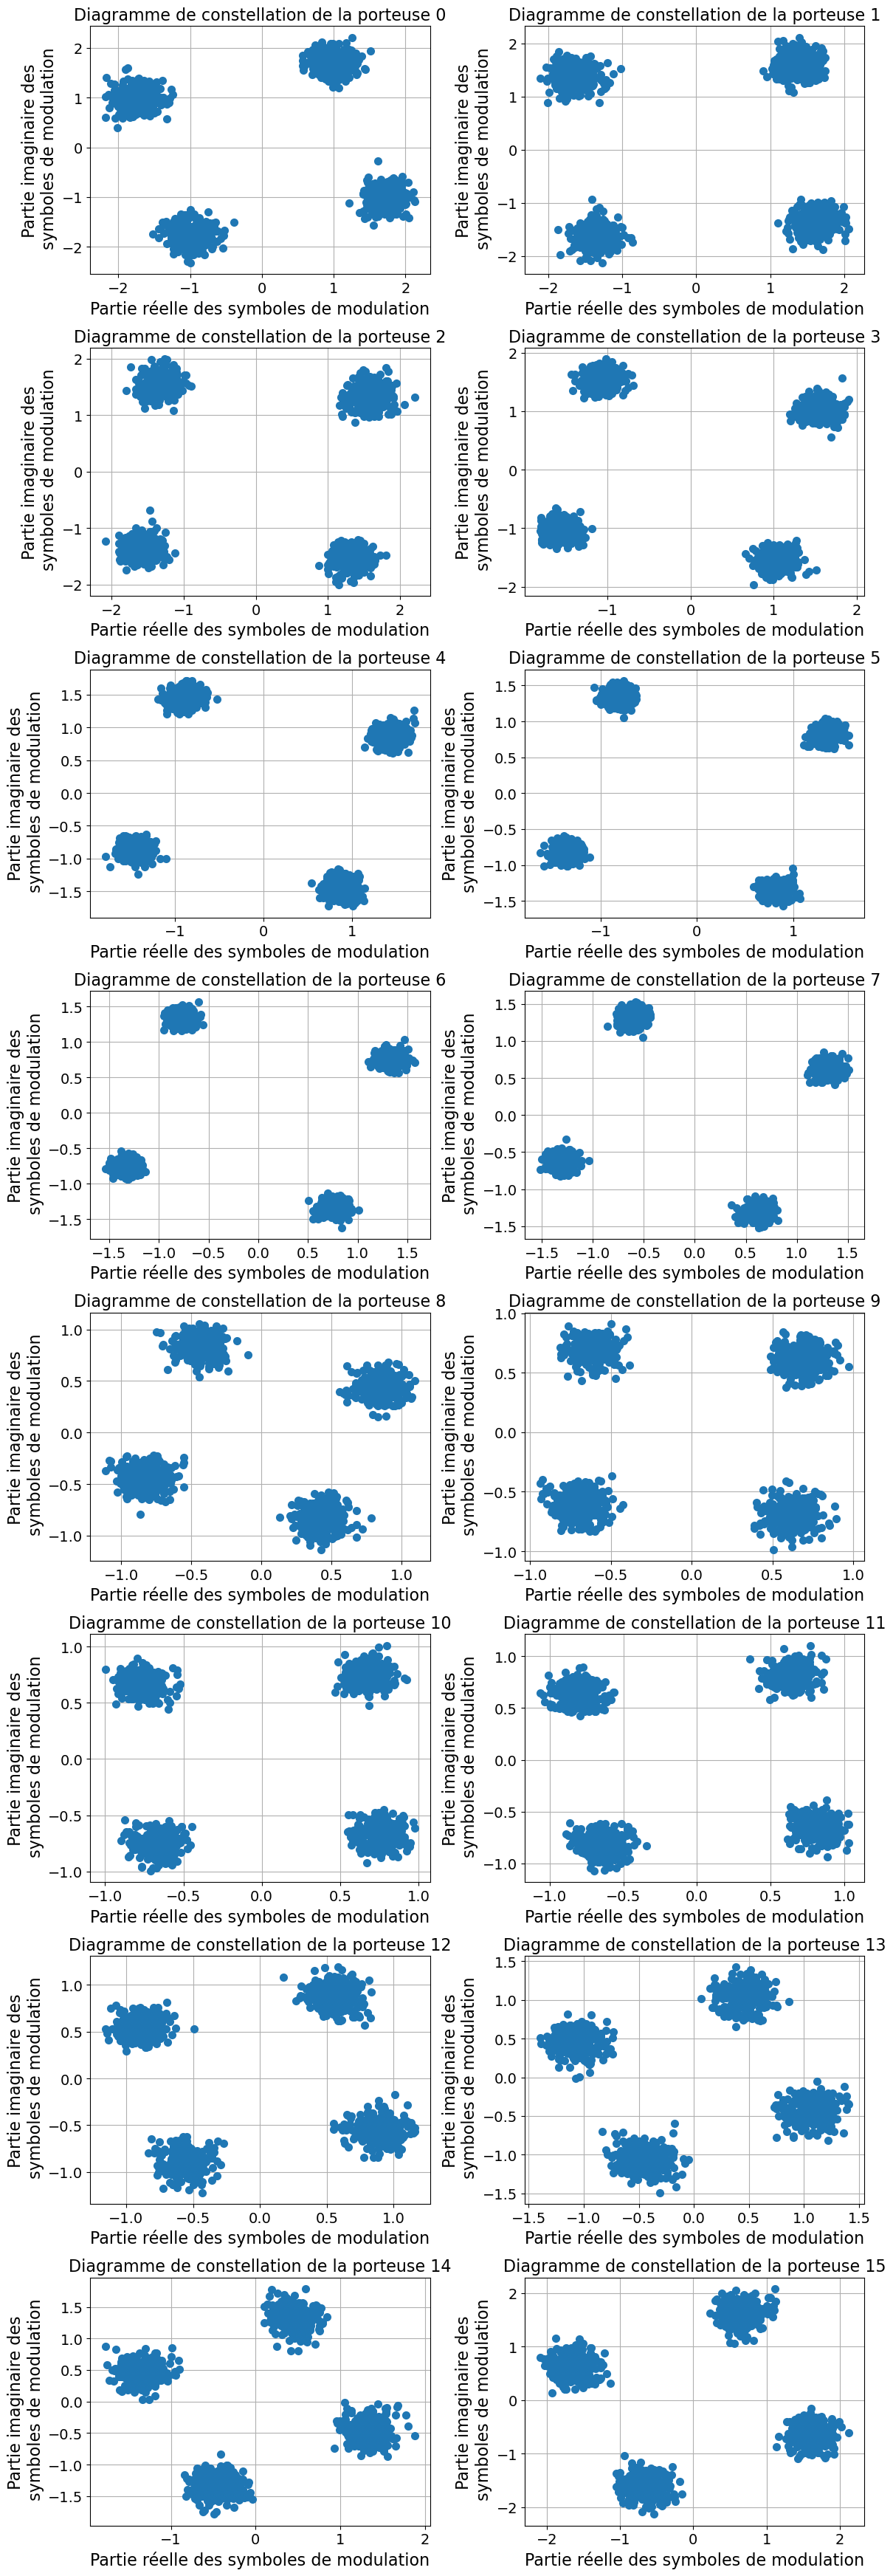

In [8]:
#####################################################################################
####     Visualisation du diagramme de constellation des sous-porteuses          ####
#####################################################################################

symbs_sp = Ofdm.symbs_ofdm_to_sp(symbs_rcv_para)
Ofdm.plot_constel_sp(symbs_sp)

<div class="alert alert-block alert-danger travail">
    
**Réponses aux questions**

<br>  
    
    
</div>

<div class="alert alert-block alert-success">
    
# **II. Préfixe cyclique et égalisation**

<div>

<div class="alert alert-block alert-info bilan">
    
## 1. Préfixe cyclique

<div>

### 1.1 Transformée de Fourier d'une convolution linéaire et FFT d'une convolution circulaire  

<br>

Comme dit plus haut et comme on l'avait vu dans le module de traitement du signal au deuxième semestre, la **convolution linéaire** dans le domaine temporel donne un produit dans le domaine des fréquences par transformée de Fourier pour des signaux continus :

$TF [(e * h)(t)] = E(f) \times H(f)$

Cela n'est plus vrai exactement vrai pour des signaux discrets. Dans ce cas, c'est la FFT de la **convolution circulaire** (notée $\circledast$) qui donne un produit dans le domaine fréquentielle :  
$FFT [(e \circledast h)(n)] = E(k) \times H(k)$

La convolution circulaire de 2 vecteurs de même taille L est définie par :  
$(e \circledast h)(n)  = \displaystyle \sum_{m=0}^{L-1} e[m].h[(n-m)_{modulo\; L}]$  

On veut vérifier ceci dans la cellule de code suivante. On donne deux vecteurs : `e` symbolisant le signal OFDM et `h` la réponse impulsionelle du canal. La convolution circulaire n'étant pas codé en Python, on l'a codé dans la fonction nommée `convolution_circulaire`. 

1. Compléter la partie "produit des FFT" de la cellule de code ci-dessous pour calculer le produit des FFT de `e` et `h`.  
<br>

2. Compléter la partie "FFT de la convolution circulaire" de la cellule de code ci-dessous pour calculer la FFT de la convolution circulaire de `e` et `h`.  
<br>

3. Compléter la partie "FFT de la convolution linéaire" de la cellule de code ci-dessous pour calculer la FFT de la convolution lineaire de `e` et `h`. On utilisera la fonction numpy `convolve` avec  mode="same" pour avoir le même nombre d'échantillons en sortie (soit 4).  
<br>

4. Afficher les résultats pour vérifier la théorie.

</div>

In [3]:
def convolution_circulaire(e, h):
    assert e.shape == h.shape, 'les 2 vecteurs doivent avoir la même taille'
    L = e.shape[0]
    output = np.zeros(L)
    for n in range(L):
        for m in range(L):
            output[n] += e[m] * h[(n - m) % L]
    return(output)

e = np.array([1,5,2,1])
h = np.array([1,2,3,4])

########### Produit des FFT ###############



###########  FFT de la convolution circulaire ###############
#Convolution circulaire de e et h

#FFT de la convolution circulaire


###########  FFT de la convolution linéaire ###############
#Convolution lineaire de e et h

#FFT de la convolution linéaire


###########  Affichage des résultats pour vérification de la théorie ###############





### 1.2 Préfixe cyclique


**1.2.1 Objectif du préfixe cyclique : d'un canal réalisant une convolution linéaire à une convolution  circulaire**  

<br> 

L'enveloppe complexe du signal OFDM $x_{EC}(t)$ est émise dans le canal à trajet multiple de réponse impulsionnelle $h(t)$. Comme celui-ci correspond à un système linéaire, on peut en déduire la sortie du canal par convolution lineaire avec sa réponse impulsionnelle :  
<br>
    
$x_{EC-RCV}(k) = [(x_{EC} * h)(k)]$  
<br>
    
Le récepteur OFDM réalise ensuite une FFT sur chaque symbole OFDM de l'enveloppe complexe du signal reçu. Cependant le résultat n'est pas égal au produit de la FFT de l'enveloppe complexe émise (qui correspond aux symboles de modulation) fois la FFT de la réponse impulsionnelle du canal puisque ce n'était pas une convolution circulaire :  
<br>

$FFT[x_{EC-RCV}(k)]_{N} \neq FFT[(x_{EC}(k)]_{N} \times FFT[h(k)]_{N}$  
<br>   

L'objectif du préfixe cyclique (en plus de servir d'intervalle de garde) est donc de faire passer le canal d'un convolution linéaire à une convolution circulaire sur la durée des symboles OFDM comme illustré sur le schéma ci-dessous:  

    
![prefixe cyclique](images/prefixe_cyclique.png)
<br>
    
Comme la convolution circulaire est une convolution modulo N, il suffit de recopier la fin des N échantillons au début de ceci sur une durée supérieure à la durée de la convolution du canal c'est à dire la durée de la réponse impulsionnelle du canal qu'on a appelé delay spread.
    
$(e \circledast h)(n)  = \displaystyle \sum_{m=0}^{N-1} e[m].h[(n-m)_{modulo\; N}] = \displaystyle \sum_{m=0}^{N-1} h[m].e[(n-m)_{modulo\; N}]$  

**1.2.2 Implémentation Python**

<br>    

On veut vérifier que l'ajout du préfixe cyclique permet de faire en sorte que le canal effectue une convolution circulaire (sur les N échantillons de la FFT) à la place d'une convolution linéaire pour pouvoir retrouver après la FFT sur l'enveloppe complexe les symboles de modulation. On fera donc 2 tests :
- Insertion du préfixe cyclique et vérification qu'on retrouve bien les symboles de modulation fois le canal ($mod(h).exp^{\displaystyle \; j.arg(h)}$) à la fréquence de la sous-porteuse qu'on compensera lors de l'égalisation  

- Insertion de zéros à la place du préfixe cyclique (pour annuler l'IIS) pour vérifier qu'avec une convolution linéaire on ne retrouve pas les symboles.

On a repris dans la cellule de code ci-dessous toute la chaîne de transmission OFDM en bande de base (c'est à dire avec l'enveloppe complexe OFDM) mais avec le préfixe cyclique et l'égalisation (qu'on traitera dans la section suivante).  
<br>

![chaine egalisation](images/chaine_ifft_BdB_egalisation.png)



On commence dans cette section par implémenter et voir l'impact du préfixe cyclique.

1. Rappeler ce qu'est le delay spread et indiquer sa valeur pour le canal choisi ici.  
<br>
    
2. En déduire sur combien d'échantillons il faut générer le préfixe cylcique pour supprimer l'IIS et avoir une convolution circulaire pour le canal.  
<br>
    
3. Compléter les sections correspondantes sur l'émetteur et le récepteur pour ajouter le préfixe cyclique.  
<br>
    
4. Visualiser le l'impact sur les diagrammes de contellation des sous-porteuses pour 6 échantillons pour le préfixe cyclique, puis 4 puis 2.  
<br>


<div class="alert alert-block alert-danger travail">
    
**Réponse aux questions**

<br>
    
    
</div>

In [ ]:
##################################################################
####      Emetteur équivalent en bande de bande               ####
##################################################################

#Génération des bits sous forme d'un vecteur
bits = np.random.binomial(1,0.5,nb_bits)
#Génération des symboles numériques sous forme d'une matrice (nombre de symboles OFDM, nombre de sous-porteuses, nombre de bits par symbole de modulation)
symbs_num = bits.reshape(nb_symb_ofdm, nb_sp, bits_par_sp)
#Génération des symboles OFDM associées à partir des symboles numériques sous forme d'une matrice (nombre de symboles OFDM, nombres de sous-porteuses)
symbs_para = Ofdm.mapping(symbs_num, mapping_table)
#Zero padding pour augmenter la fréquence d'échantillonnage d'un facteur 2
symbs_para_pad = Ofdm.zero_pad(symbs_para, nb_zero)
# Génération de l'enveloppe complexe du signal OFDM à iFFT sous forme d'une matrice 
ec_para = np.fft.ifft(symbs_para_pad)

########## A COMPLETER  : AJOUT PREFIXE CYCLIQUE ################
#Ajout d'un préfixe cyclique




#################################################################

#Convertion parallèle-série = mis à plat de la matrice avec la fonction numpy ravel
ec_OFDM = np.ravel(ec_para_pc)


##################################################################
####   Canal équivalent passe-bas à trajets multiples         ####
##################################################################
#Convolution linéaire du canal
ec_OFDM_rcv = np.convolve(ec_OFDM, ceq)

###################################################################
####          Récepteur équivalent en bande de base            ####
###################################################################

# Conversion série parallèle pour pouvoir faire un FFT sur chaque groupe de 38 symboles (6 echantillons pour le préfixe cylcique, 16 symboles de modulations des sous-porteuses, 16 zéros)
ec_rcv_para_pc= ec_OFDM_rcv[0:len(ec_OFDM)].reshape(nb_symb_ofdm, nb_zero+nb_sp+nb_ech_pc)

######## A COMPLETER  : SUPPRESSION DU PREFIXE CYCLIQUE ###########
#Suppression du préfixe cyclique


#################################################################

# Passage de l'enveloppe complexe aux symboles de modulation avec une FFT
symbs_rcv_pad_para = np.fft.fft(ec_rcv_para)
# Suppression du zéro padding
symbs_rcv_para = Ofdm.rem_zero_pad(symbs_rcv_pad_para, nb_sp)
# Conversion parallèle série : mise à plat de la matrice
symbs_rcv = np.ravel(symbs_rcv_para)
# Détection
symbs_detect = Ofdm.detection(symbs_rcv, mapping_table)
# Demapping
bits_rcv = Ofdm.demapping(symbs_detect, mapping_table)

In [ ]:
print(f'Les 32 premiers bits émis sont : \n {bits[0:32]}\n')
print(f'Les 32 premiers bits reçus sont : \n {bits_rcv[0:32]}')

In [ ]:
#####################################################################################
####     Visualisation du diagramme de constellation des sous-porteuses          ####
#####################################################################################

symbs_sp = Ofdm.symbs_ofdm_to_sp(symbs_rcv_para)
Ofdm.plot_constel_sp(symbs_sp)



### 1.3 Insertion de zeros à la place du préfixe cyclique  



On veut vérifier que si on insère juste des zéros à la place du préfixe cyclique, on compense bien l'IIS mais que à cause de la convolution linéaire du canal et non circulaire, on ne retrouve pas les symboles de modulation.

1. Remplacer le préfixe cyclique par une séquence de 6 zéros : on génèrera une matrice de (1000,6) zéros à la place du préfixe cyclique et on la concatènera aux symboles OFDM.  
<br>
    
2. Relancer la cellule suivante avec les diagrammes de constellation et vérifier que ceux-ci comprennent un nuage de point.   
  
</div>


In [79]:
##################################################################
####      Emetteur équivalent en bande de bande               ####
##################################################################

#Génération des bits sous forme d'un vecteur
bits = np.random.binomial(1,0.5,nb_bits)
#Génération des symboles numériques sous forme d'une matrice (nombre de symboles OFDM, nombre de sous-porteuses, nombre de bits par symbole de modulation)
symbs_num = bits.reshape(nb_symb_ofdm, nb_sp, bits_par_sp)
#Génération des symboles OFDM associées à partir des symboles numériques sous forme d'une matrice (nombre de symboles OFDM, nombres de sous-porteuses)
symbs_para = Ofdm.mapping(symbs_num, mapping_table)
#Zero padding pour augmenter la fréquence d'échantillonnage d'un facteur 2
symbs_para_pad = Ofdm.zero_pad(symbs_para, nb_zero)
# Génération de l'enveloppe complexe du signal OFDM à iFFT sous forme d'une matrice 
ec_para = np.fft.ifft(symbs_para_pad)

########## A COMPLETER  : AJOUT DE ZEROS ################
#Ajout d'un préfixe cyclique




#################################################################

#Convertion parallèle-série = mis à plat de la matrice avec la fonction numpy ravel
ec_OFDM = np.ravel(ec_para_pc)


##################################################################
####   Canal équivalent passe-bas à trajets multiples         ####
##################################################################
#Convolution linéaire du canal
ec_OFDM_rcv = np.convolve(ec_OFDM, ceq)

###################################################################
####          Récepteur équivalent en bande de base            ####
###################################################################

# Conversion série parallèle pour pouvoir faire un FFT sur chaque groupe de 38 symboles (6 echantillons pour le préfixe cylcique, 16 symboles de modulations des sous-porteuses, 16 zéros)
ec_rcv_para_pc= ec_OFDM_rcv[0:len(ec_OFDM)].reshape(nb_symb_ofdm, nb_zero+nb_sp+nb_ech_pc)
#Suppression du préfixe cyclique
ec_rcv_para = ec_rcv_para_pc[:,nb_ech_pc:]
# Passage de l'enveloppe complexe aux symboles de modulation avec une FFT
symbs_rcv_pad_para = np.fft.fft(ec_rcv_para)
# Suppression du zéro padding
symbs_rcv_para = Ofdm.rem_zero_pad(symbs_rcv_pad_para, nb_sp)
# Conversion parallèle série : mise à plat de la matrice
symbs_rcv = np.ravel(symbs_rcv_para)
# Détection
symbs_detect = Ofdm.detection(symbs_rcv, mapping_table)
# Demapping
bits_rcv = Ofdm.demapping(symbs_detect, mapping_table)

In [ ]:
#####################################################################################
####     Visualisation du diagramme de constellation des sous-porteuses          ####
#####################################################################################

symbs_sp = Ofdm.symbs_ofdm_to_sp(symbs_rcv_para)
Ofdm.plot_constel_sp(symbs_sp)

<div class="alert alert-block alert-info bilan">
    
## 2. Egalisation

<div>


On a repris dans la cellule de code ci-dessous toute la chaîne de transmission OFDM en bande de base (c'est à dire avec l'enveloppe complexe OFDM). La cellule de code suivante permet d'afficher le diagramme de constellation des sous-porteuses. On veut voir maintenant l'impact de l'égalisation avec préambule (en plus du préfixe cylcique) sur le diagramme de constellation des sous-porteuses.
 
1. En regardant le cours, regarder le principe de l'égalisation avec préambule et zero-forcing.  
<br>
    
2. Compléter la section correspondante sur l'émetteur pour ajouter le préambule BPSK  $[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1]$.  
<br>
    
3. Compléter les sections correspondantes sur le récepteur pour :
  - Calculer un vecteur avec les valeurs complexes par lesquelles multiplier chaque sous-porteuses pour retrouver le symbole émis
  - Multiplier les symboles reçus pour les différentes sous-porteuses par ce vecteur
<br>   
    
4. Visualiser le l'impact sur les diagrammes de contellation des sous-porteuses de l'égalisation.  
<br>
    
5. Conclure sur le préfixe cyclique et l'égalisation.
    
  
</div>

In [80]:
##################################################################
####      Emetteur équivalent en bande de bande               ####
##################################################################

#Génération des bits sous forme d'un vecteur
bits = np.random.binomial(1,0.5,nb_bits)
#Génération des symboles numériques sous forme d'une matrice (nombre de symboles OFDM, nombre de sous-porteuses, nombre de bits par symbole de modulation)
symbs_num = bits.reshape(nb_symb_ofdm, nb_sp, bits_par_sp)
#Génération des symboles OFDM associées à partir des symboles numériques sous forme d'une matrice (nombre de symboles OFDM, nombres de sous-porteuses)
symbs_para = Ofdm.mapping(symbs_num, mapping_table)

########## A COMPLETER  : AJOUT DU PREAMBULE ET PREFIXE CYCLIQUE ################
#Ajout d'un préambule



#################################################################################

#Zero padding pour augmenter la fréquence d'échantillonnage d'un facteur 2
symbs_para_pad = Ofdm.zero_pad(symbs_para_pream, nb_zero)
# Génération de l'enveloppe complexe du signal OFDM à iFFT sous forme d'une matrice 
ec_para = np.fft.ifft(symbs_para_pad)


########## A COMPLETER  : AJOUT DU PREFIXE CYCLIQUE ################
#Ajout d'un préfixe cyclique



####################################################################

#Convertion parallèle-série = mis à plat de la matrice avec la fonction numpy ravel
ec_OFDM = np.ravel(ec_para_pc)
symbs_para_pream

##################################################################
####   Canal équivalent passe-bas à trajets multiples         ####
##################################################################
#Convolution linéaire du canal
ec_OFDM_rcv = np.convolve(ec_OFDM, ceq)

###################################################################
####          Récepteur équivalent en bande de base            ####
###################################################################

# Conversion série parallèle pour pouvoir faire un FFT sur chaque groupe de 38 symboles (6 echantillons pour le préfixe cylcique, 16 symboles de modulations des sous-porteuses, 16 zéros)
ec_rcv_para_pc= ec_OFDM_rcv[0:len(ec_OFDM)].reshape(nb_symb_ofdm+1, nb_zero+nb_sp+nb_ech_pc)

######## A COMPLETER  : SUPPRESSION DU PREFIXE CYCLIQUE ###########
#Suppression du préfixe cyclique


#################################################################

# Passage de l'enveloppe complexe aux symboles de modulation avec une FFT
symbs_rcv_pad_para = np.fft.fft(ec_rcv_para)
# Suppression du zéro padding
symbs_rcv_para = Ofdm.rem_zero_pad(symbs_rcv_pad_para, nb_sp)

######## A COMPLETER  : EGALISATION ###########
#Récupération du préambule


#Estimation du canal (préambule reçu sur préambule émis)


#Suppression du préambule des symboles OFDM


#Egalisation zero-forcing (broadcasting)


#################################################################

# Conversion parallèle série : mise à plat de la matrice
symbs_rcv = np.ravel(symbs_rcv_para_egal)
# Détection
symbs_detect = Ofdm.detection(symbs_rcv, mapping_table)
# Demapping
bits_rcv = Ofdm.demapping(symbs_detect, mapping_table)

In [ ]:
print(f'Les 32 premiers bits émis sont : \n {bits[0:32]}\n')
print(f'Les 32 premiers bits reçus sont : \n {bits_rcv[0:32]}')

In [ ]:
#####################################################################################
####     Visualisation du diagramme de constellation des sous-porteuses          ####
#####################################################################################

symbs_sp = Ofdm.symbs_ofdm_to_sp(symbs_rcv_para_egal)
Ofdm.plot_constel_sp(symbs_sp)

<div class="alert alert-block alert-danger travail">

**Synthèse :**

<br>
    
 </div>